## Generalized Random Forest Module: Use Cases and Examples

Causal Forests and [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf) are a flexible method for estimating treatment effect heterogeneity with Random Forests. The `econml.grf` module implements a high-performance Cython version of the [`grf`](https://github.com/grf-labs/grf) R-package, with support for CausalForests, IVForests and RegressionForests. The module provides estimators that adhere to the scikit-learn fit and predict API, as well as providing methods for uncertainty quantification and confidence intervals.

Within the EconML SDK we use these estimators as final models for CATE estimation, such as in the case of `econml.dml.CausalForestDML`, where we combine a Causal Forest with Double Machine Learning, to residualize the treatment and outcome and call the `econml.grf.CausalForest` on the residuals. Similarly, the `econml.dr.ForestDRLearner` uses an `econml.grf.RegressionForest` as a final stage estimator on the doubly robust targets estimated by the first stage. The estimators here should primarily be used in conjunction with CateEstimators and not as standalone, but we provide here examples of their direct usage functionality.

The EconML SDK implements the following Generalized Random Forest variants:

* `CausalForest`: suitable for many continuous or discrete treatments, when there is no unobserved confounding

* `CausalIVForest`: suitable for many continuous or discrete treatments, when there is unobserved confounding and access to an instrument

* `RegressionForest`: an analogue of `sklearn.ensemble.RandomForestRegressor`, but with support for confidence intervals.

If you also have multiple outcomes, then the class `econml.grf.MultiOutputGRF`, is a wrapper class that wraps any generalized random forest and enables support for multiple outcomes by fitting a separate forest for each target outcome.

Our estimators provide support for the heterogeneity criterion as outlined in [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf), using `criterion='het'`, as well as a mean squared error criterion that penalizes high-variance splits, using `criterion='mse'`.[Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf).

Uncertainty quantification and confidence intervals is computed via the Bootstrap-of-Little-Bags approach outlined in [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf).

The tree data structure that is used to store each tree is compatible with `sklearn.tree._tree.Tree` and so scikit-learn functionalities on trees can be applied to our trained trees (e.g. tree plotting).

In [1]:
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.dml import CausalForestDML
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

### 1. Causal Forest : Heterogeneous Causal effects with no unobserved confounders

In [20]:
np.random.seed(42)
n_samples = 2000
n_features = 10
n_treatments = 1

def true_te(X) :
    return np.hstack(
        [
            (X[:, [0]] > 0) * X[:, [0]],
            np.ones((X.shape[0], n_treatments - 1)) * np.arange(1, n_treatments).reshape(1, -1)
        ]
    )

In [21]:
X = np.random.normal(0, 1, size = (n_samples, n_features))
T = np.random.normal(0, 1, size = (n_samples, n_treatments))

In [22]:
for t in range(n_treatments) :
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))

In [23]:
y = np.sum(
    true_te(T) * T, 
    axis = 1,
    keepdims = True
) + np.random.normal(0, 0.5, size = (n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [44]:
causal_forest = CausalForest(
    criterion = 'het',
    n_estimators = 400,
    min_samples_leaf = 5,
    max_depth = None,
    min_var_fraction_leaf = None, 
    min_var_leaf_on_val = True,
    min_impurity_decrease = 0,
    max_samples = 0.45,
    min_balancedness_tol = 0.45,
    warm_start = False,
    inference = True,
    fit_intercept = True,
    subforest_size = 4,
    honest = True,
    verbose = 0,
    n_jobs = -1,
    random_state = 42
)

In [45]:
causal_forest.fit(
    X = X, T = T, y = y
)

CausalForest(criterion='het', min_impurity_decrease=0, min_var_leaf_on_val=True,
             n_estimators=400, random_state=42)

In [46]:
point, lb, ub = causal_forest.predict(X_test, interval = True, alpha = 0.01)

In [47]:
point = causal_forest.predict(X_test)

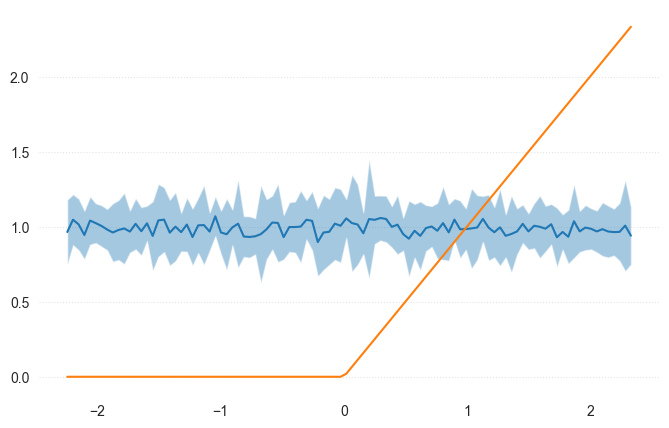

In [38]:
fig, ax = plt.subplots(figsize = (8, 5))
for t in range(n_treatments) :
    ax.plot(X_test[:, 0], point[:, t])
    if causal_forest.inference :
        ax.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha = 0.4)
    ax.plot(X_test[:, 0], true_te(X_test)[:, t])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

In [51]:
X

array([[-1.0856306 ,  0.99734545,  0.2829785 , ..., -0.42891263,
         1.26593626, -0.8667404 ],
       [-0.67888615, -0.09470897,  1.49138963, ...,  2.18678609,
         1.0040539 ,  0.3861864 ],
       [ 0.73736858,  1.49073203, -0.93583387, ..., -1.4286807 ,
        -0.14006872, -0.8617549 ],
       ...,
       [ 0.20550325,  0.17705244, -1.89590017, ...,  0.78494693,
        -0.01859838,  0.1681414 ],
       [-0.44510093, -0.23189351, -0.82677712, ...,  0.11978233,
        -1.19639932,  2.86473424],
       [ 0.90859663,  0.720665  ,  0.4094029 , ..., -1.40283982,
         1.04454086,  0.36928112]])

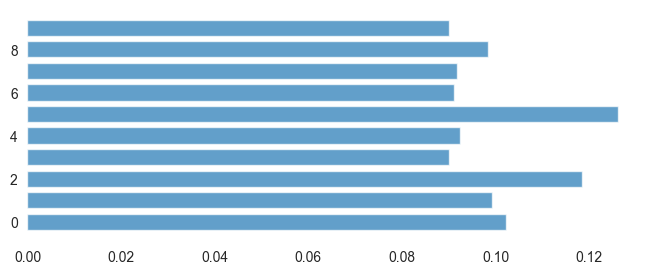

In [57]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.barh(
    range(10),
    causal_forest.feature_importances(max_depth = 4, depth_decay_exponent = 2.0),
    alpha = 0.7,
    height = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.show()

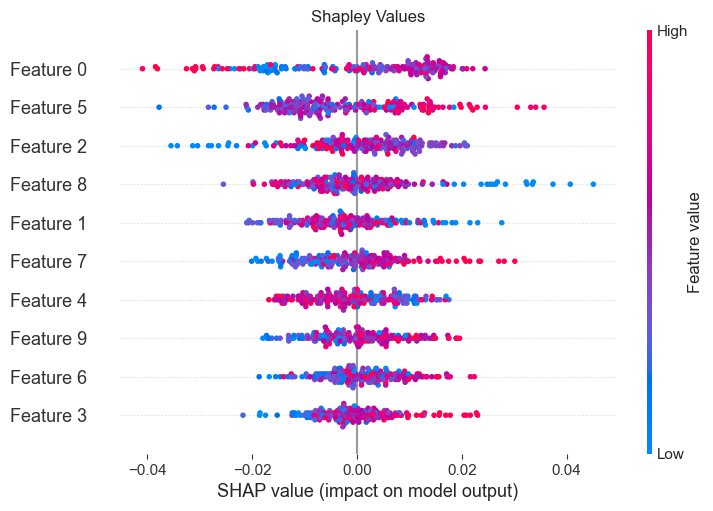

In [59]:
import shap
explainer = shap.Explainer(causal_forest, shap.maskers.Independent(X, max_samples = 100))
shap_values = explainer(X[:200])
shap.plots.beeswarm(shap_values, show = False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Shapley Values')
plt.show()

In [60]:
causal_forest.decision_path(X_test[:1])

(<1x47452 sparse matrix of type '<class 'numpy.int64'>'
 	with 3122 stored elements in Compressed Sparse Row format>,
 array([    0,   121,   242,   357,   476,   591,   708,   827,   948,
         1073,  1188,  1311,  1430,  1545,  1666,  1781,  1904,  2027,
         2146,  2269,  2392,  2511,  2632,  2745,  2864,  2983,  3100,
         3219,  3340,  3461,  3580,  3695,  3816,  3939,  4060,  4181,
         4298,  4421,  4542,  4663,  4768,  4891,  5010,  5135,  5256,
         5373,  5488,  5603,  5722,  5843,  5960,  6077,  6198,  6319,
         6444,  6565,  6686,  6807,  6928,  7041,  7160,  7275,  7400,
         7521,  7636,  7759,  7878,  7995,  8114,  8233,  8352,  8473,
         8594,  8711,  8824,  8941,  9060,  9181,  9292,  9419,  9538,
         9655,  9768,  9885, 10004, 10119, 10236, 10355, 10474, 10589,
        10708, 10829, 10942, 11063, 11178, 11297, 11414, 11531, 11648,
        11765, 11882, 11995, 12110, 12231, 12346, 12467, 12586, 12703,
        12824, 12939, 13056, 1

In [62]:
print(causal_forest.apply(X_test[:1]))

[[ 97  50  90  11 100  19 102 106 119   5  10  46  57  49  22  91 109 103
   18  83  88  28  64  19  68  87  88 102  18   9  42  17  86   6 112  28
   89   4  13  21  89  33   9  32  64  17   9  10  45  78 115   3  98   4
   90 118  93 102  47 116  85  27  10   3 112 106  80  92  29  90  21  59
  114  52 109  70  17  78  80  26  59  74  49  29 104 111  40 105  26  40
    8  37  16  19  70   2   6  90  47  28   8  83 102 101   8 118   9 105
  114 101  59  79  83 105  66  20   4 114  38  24  79  15 107  78  16  36
   90   6  11  60  30  76  23  21  14  31  53 105 104  99  95 106  88  20
   45   4  21  25  11   3  81 101  51   5  82 107  97  84  82  67  31  27
   56 104  33  45  42  17   7  79  95  25 106 109 100  15  11  86  15 107
   91  91   5   7  63  22  50  71 111  95  18   7  95  79  91  54  53  12
  111 119  22  70  13  86  28  98  15 103   7  20  61  19   5 106  28  53
  100  97  24 100  97  22  70  12 113  40  99 114  26  17 103 117  16  47
   66  57  72 113  65  20 105 119  45 

### 2. Causal IV Forest : Heterogeneous causal effects with unobserved confounders

In [63]:
np.random.seed(42)
n_samples = 2000
n_features = 10
n_treatments = 2
def true_te(X):
    return np.hstack([X[:, [0]] > 0, np.ones((X.shape[0], n_treatments - 1))])

In [65]:
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]

In [66]:
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10 * U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [67]:
causal_iv_forest = CausalIVForest(
    criterion = 'mse',
    n_estimators = 400,
    min_samples_leaf = 40,
    min_var_fraction_leaf = 0.1,
    min_var_leaf_on_val = True,
    min_impurity_decrease = 0.001,
    max_samples = 0.45,
    max_depth = None,
    warm_start = False,
    inference = True,
    subforest_size = 4,
    honest = True,
    verbose = 0,
    n_jobs = -1,
    random_state = 42
)

In [68]:
causal_iv_forest.fit(X = X, T = T, y = y, Z = Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=400, random_state=42)

In [69]:
point, lb, ub = causal_iv_forest.predict(X_test, interval = True, alpha = 0.01)

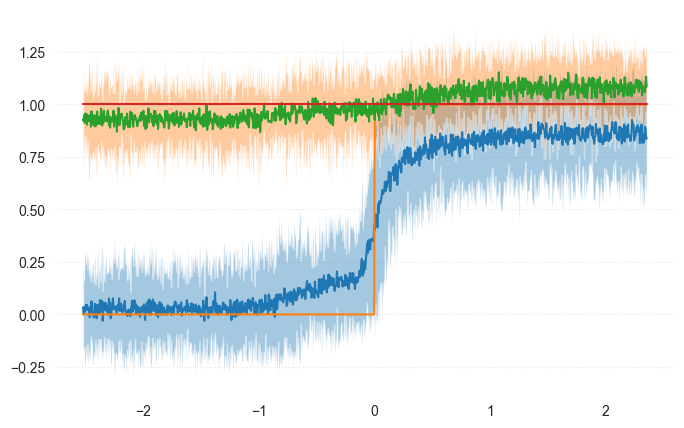

In [70]:
fig, ax = plt.subplots(figsize = (8, 5))
for t in range(n_treatments) :
    ax.plot(X_test[:, 0], point[:, t])
    if causal_forest.inference :
        ax.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha = 0.4)
    ax.plot(X_test[:, 0], true_te(X_test)[:, t])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

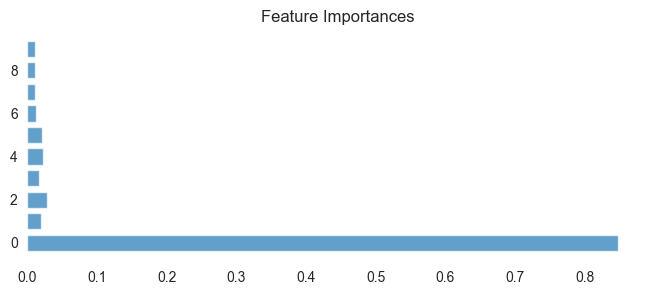

In [73]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.barh(
    range(10),
    causal_iv_forest.feature_importances(max_depth = 4, depth_decay_exponent = 2.0),
    alpha = 0.7,
    height = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.title('Feature Importances')
plt.show()

In [77]:
explainer = shap.Explainer(causal_iv_forest, shap.maskers.Independent(X, max_samples = 100))
shap_values = explainer(X[:200])

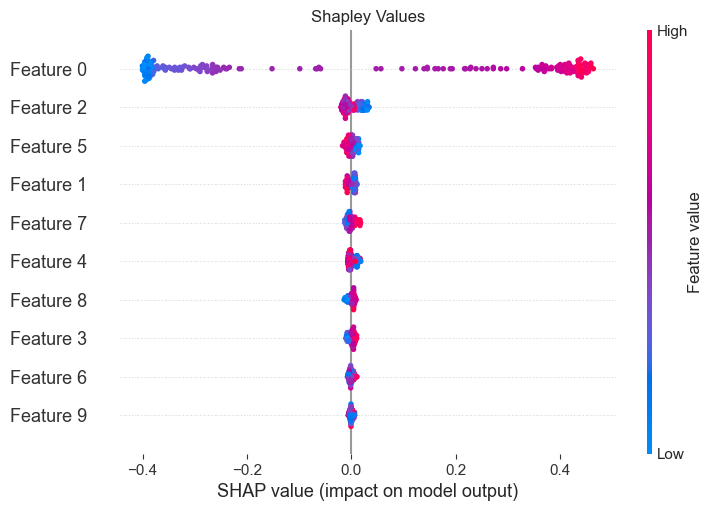

In [78]:
shap.plots.beeswarm(shap_values[:, :, 0], show = False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Shapley Values')
plt.show()

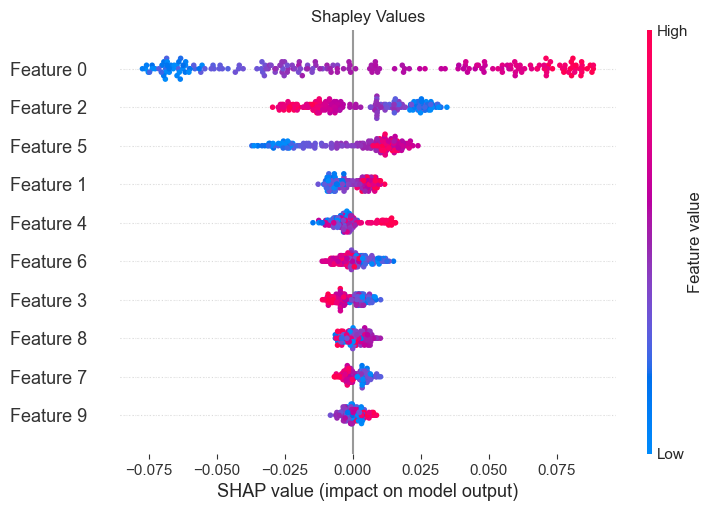

In [79]:
shap.plots.beeswarm(shap_values[:, :, 1], show = False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Shapley Values')
plt.show()

In [80]:
causal_iv_forest[0].decision_path(X_test[:1])

<1x15 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [81]:
causal_iv_forest[0].apply(X_test[:1])

array([4])

### 3. Regression Forest : Random Forest Regressor with Confidence intervals

In [82]:
np.random.seed(42)
n_samples = 2000
n_features = 10
n_outputs = 2
def true_te(X):
    return np.hstack([X[:, [0]] ** 2 + 1, np.ones((X.shape[0], n_outputs - 1))])

In [83]:
X = np.random.normal(0, 1, size=(n_samples, n_features))
y = true_te(X) + 0.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [84]:
reg_forest = RegressionForest(
    n_estimators = 400,
    min_samples_leaf = 5,
    max_depth = None,
    min_impurity_decrease = 0.0,
    max_samples = 0.45,
    min_balancedness_tol = 0.45,
    warm_start = False,
    inference = True,
    subforest_size = 4,
    honest = True,
    verbose = 0,
    n_jobs = -1,
    random_state = 42
)

In [85]:
reg_forest.fit(X = X, y = y)

RegressionForest(n_estimators=400, random_state=42)

In [86]:
point, lb, ub = reg_forest.predict(
    X_test, 
    interval = True,
    alpha = 0.01
)

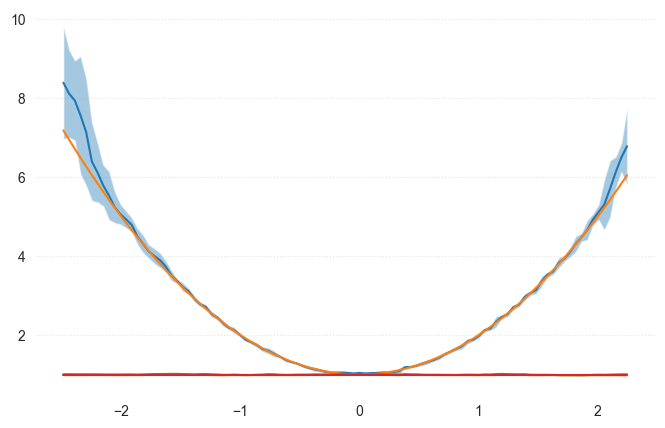

In [87]:
fig, ax = plt.subplots(figsize = (8, 5))
for t in range(n_treatments) :
    ax.plot(X_test[:, 0], point[:, t])
    if causal_forest.inference :
        ax.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha = 0.4)
    ax.plot(X_test[:, 0], true_te(X_test)[:, t])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

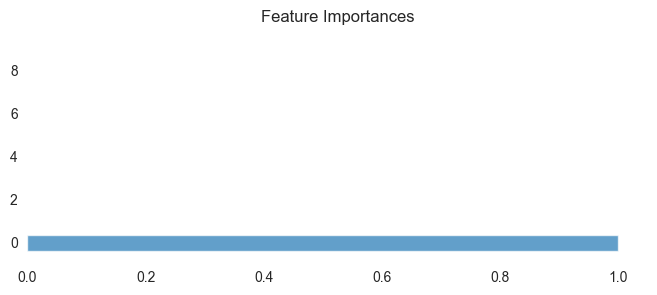

In [88]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.barh(
    range(10),
    reg_forest.feature_importances(max_depth = 4, depth_decay_exponent = 2.0),
    alpha = 0.7,
    height = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.title('Feature Importances')
plt.show()

In [89]:
explainer = shap.Explainer(reg_forest, shap.maskers.Independent(X, max_samples = 100))
shap_values = explainer(X[:200])

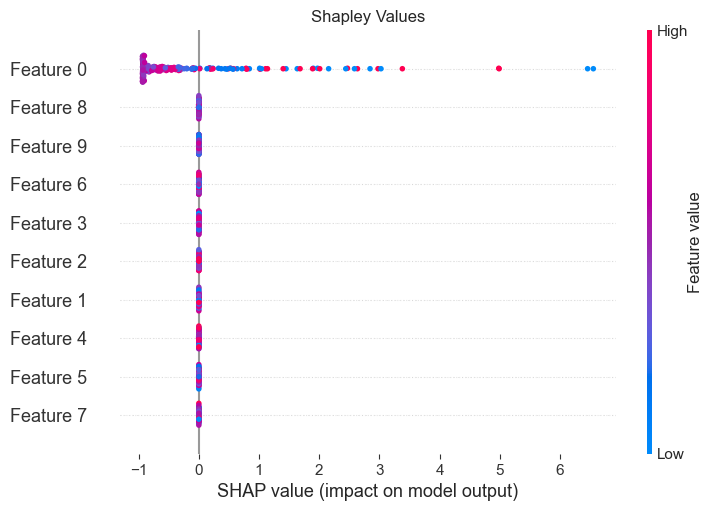

In [90]:
shap.plots.beeswarm(shap_values[:, :, 0], show = False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Shapley Values')
plt.show()

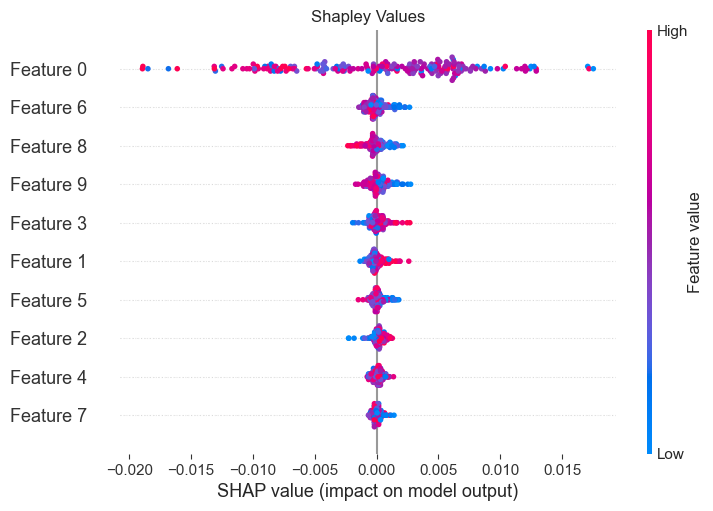

In [91]:
shap.plots.beeswarm(shap_values[:, :, 1], show = False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Shapley Values')
plt.show()

### 4. Combining with Double Machine Learning

In [92]:
np.random.seed(42)
n_samples = 5000
n_features = 10
n_treatments = 3
n_outputs = 2
def true_te(X):
    return np.hstack(
        [(X[:, [0]] > 0) * X[:, [0]],
         np.ones((X.shape[0], n_treatments - 1)) * np.arange(1, n_treatments).reshape(1, -1)]
    )

In [93]:
X = np.random.normal(0, 1, size=(n_samples, n_features))
W = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))

In [94]:
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 5.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
y = np.tile(y, (1, n_outputs))
for j in range(n_outputs):
    y[:, j] = (j + 1) * y[:, j]
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [95]:
causal_dml = CausalForestDML(
    cv = 2,
    criterion = 'mse',
    n_estimators = 400,
    min_var_fraction_leaf = 0.1,
    min_var_leaf_on_val = True,
    verbose = 0,
    discrete_treatment = False,
    n_jobs = -1,
    random_state = 42
)

In [98]:
causal_dml.fit(
    Y = y,
    T = T,
    X = X,
    W = W
)

In [99]:
res = causal_dml.const_marginal_effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=.01)

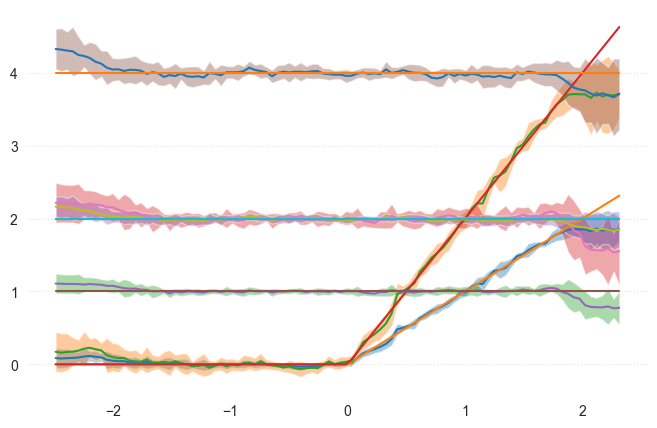

In [100]:
fig, ax = plt.subplots(figsize = (8, 5))
for t in range(n_treatments) :
    for j in range(n_outputs):
        ax.plot(X_test[:, 0], point[:, j, t])
        ax.fill_between(X_test[:, 0], lb[:, j, t], ub[:, j, t], alpha = 0.4)
        ax.plot(X_test[:, 0], (j + 1) * true_te(X_test)[:, t])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

In [101]:
res.summary_frame()

point_estimate  stderr   zstat  pvalue  ci_lower  ci_upper
X  Y  T                                                             
0  Y0 T0           0.086   0.053   1.619   0.105    -0.018     0.190
      T1           1.109   0.053  20.954   0.000     1.005     1.212
      T2           2.164   0.053  40.517   0.000     2.059     2.269
   Y1 T0           0.172   0.106   1.619   0.105    -0.036     0.380
      T1           2.217   0.106  20.954   0.000     2.010     2.425
...                  ...     ...     ...     ...       ...       ...
99 Y0 T1           0.776   0.090   8.649   0.000     0.600     0.952
      T2           1.855   0.094  19.632   0.000     1.670     2.040
   Y1 T0           3.714   0.126  29.386   0.000     3.466     3.962
      T1           1.552   0.179   8.649   0.000     1.200     1.904
      T2           3.710   0.189  19.632   0.000     3.340     4.080

[600 rows x 6 columns]

In [102]:
res = causal_dml.effect_inference(
    X_test,
    T0 = np.zeros((X_test.shape[0], n_treatments)),
    T1 = np.ones((X_test.shape[0], n_treatments))
)
point = res.point_estimate
lb, ub = res.conf_int(alpha=0.01)

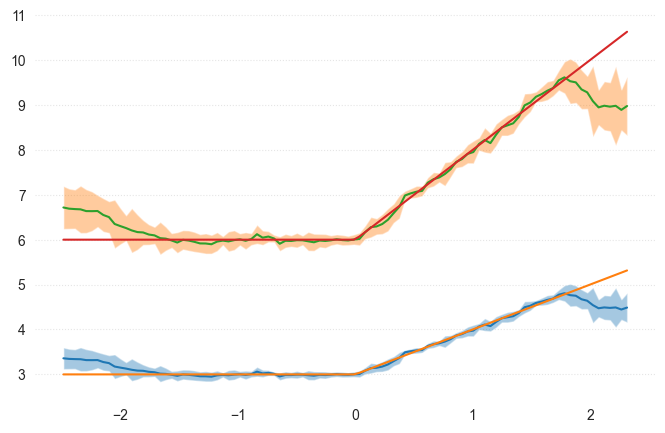

In [104]:
fig, ax = plt.subplots(figsize = (8, 5))

for j in range(n_outputs):
    ax.plot(X_test[:, 0], point[:, j])
    ax.fill_between(X_test[:, 0], lb[:, j], ub[:, j], alpha = 0.4)
    ax.plot(X_test[:, 0], (j + 1) * np.sum(true_te(X_test), axis=1))
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

In [105]:
res.summary_frame()

point_estimate  stderr   zstat  pvalue  ci_lower  ci_upper
X  Y                                                             
0  Y0           3.359   0.092  36.354     0.0     3.177     3.540
   Y1           6.717   0.185  36.354     0.0     6.355     7.079
1  Y0           3.345   0.087  38.605     0.0     3.175     3.515
   Y1           6.690   0.173  38.605     0.0     6.351     7.030
2  Y0           3.341   0.084  39.699     0.0     3.176     3.506
...               ...     ...     ...     ...       ...       ...
97 Y1           8.982   0.342  26.280     0.0     8.312     9.651
98 Y0           4.445   0.088  50.235     0.0     4.272     4.619
   Y1           8.891   0.177  50.235     0.0     8.544     9.237
99 Y0           4.488   0.127  35.357     0.0     4.239     4.737
   Y1           8.976   0.254  35.357     0.0     8.478     9.474

[200 rows x 6 columns]

In [107]:
causal_dml.feature_importances_

array([[0.97946635, 0.00293155, 0.00174147, 0.00186799, 0.00264579,
        0.00194189, 0.00282688, 0.0013707 , 0.00401503, 0.00119236],
       [0.97946635, 0.00293155, 0.00174147, 0.00186799, 0.00264579,
        0.00194189, 0.00282688, 0.0013707 , 0.00401503, 0.00119236]])

In [110]:
causal_dml[0]

[GRFTree(max_features='auto', min_var_leaf=0.02068807856295478,
         min_var_leaf_on_val=True, random_state=1273642419),
 GRFTree(max_features='auto', min_var_leaf=0.02068807856295478,
         min_var_leaf_on_val=True, random_state=1273642419)]